In [1]:
%pip install pyspark pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 31 kB/s 
     |████████████████████████████████| 199 kB 51.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=f3b53e9ed5cfda8d8b23c51177b6190ada503689dd2e0a174c5b42edd9168f16
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
# Import libraries
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes

In [3]:
# Create a SparkSession

spark = SparkSession.builder.getOrCreate()

In [7]:
# Read in the data xls file
df = spark.read.csv('spambase.data', header=False, inferSchema=True)


In [8]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: double (nullable = tru

In [9]:
# print the first 5 rows of the DataFrame
df.show(5)

+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+----+----+----+
| _c0| _c1| _c2|_c3| _c4| _c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|_c41|_c42|_c43|_c44|_c45|_c46|_c47|_c48| _c49|_c50| _c51| _c52| _c53| _c54|_c55|_c56|_c57|
+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+----+----+----+
| 0.0|0.64|0.64|0.0|0.32| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0|0.64| 0.0| 0.0| 0.0|0.32| 0.0|1.29|1.93| 0.0|0.96| 0.0| 0

In [10]:
# As states Last column is the label
# Rename the last column to label

df = df.withColumnRenamed('_c57', 'label')

In [11]:
df.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: double (nullable = tru

([<matplotlib.patches.Wedge at 0x7f3bba039790>,
 [Text(0.3594305600470041, 1.0396199654221234, 'spam'),
  Text(-0.35943046271075624, -1.0396199990744368, 'ham')],
 [Text(0.19605303275291128, 0.5670654356847945, '39.4%'),
  Text(-0.19605297966041246, -0.5670654540406018, '60.6%')])

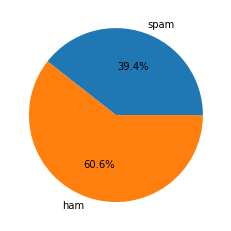

In [12]:
# Lets check the number of spam and ham emails and draw a pie chart

spam = df.filter(df.label == 1).count()
ham = df.filter(df.label == 0).count()

# plot a pie chart
plt.pie([spam, ham], labels=['spam', 'ham'], autopct='%1.1f%%')

## The data looks good, 40-60% is acceptable for the modelling

# Splitting the dataset

In [13]:
# Split the data into X and y
assembler = VectorAssembler(inputCols=df.columns[:-1], outputCol='features')
X = assembler.transform(df)
y = df.select('label')


# Split the data into train and test
train, test = X.randomSplit([0.7, 0.3], seed=42)

# Build a Naive Bayes model

nb = NaiveBayes(labelCol='label', featuresCol='features', smoothing=1.0, modelType='multinomial')

# Fit the model to the training data
nb_model = nb.fit(train)


# Evaluating NaiveBayes

In [14]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
#  ROC curve
# https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

Accuracy:  0.7974105102817974
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  138|
|    0|       0.0|  644|
|    1|       1.0|  403|
|    0|       1.0|  128|
+-----+----------+-----+

AUC:  0.7895568559470563


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


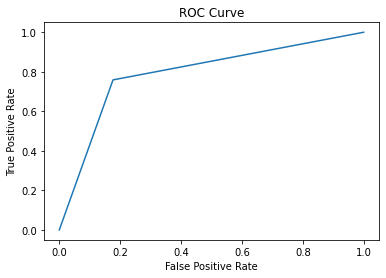

In [15]:
# Evaluate the model by predicting the test data and giving the speed of the model, Error rate, ROC and AUC

# Cache for accuracies and AUC
output_cache = {
  "NaiveBayes": {
    "accuracy": 0.0,
    "AUC": 0.0
  },
  "MLP": {
    "accuracy": 0.0,
    "AUC": 0.0
  },
  "AdaBoost": {
    "accuracy": 0.0,
    "AUC": 0.0
  }
}

predictions = nb_model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

accuracy = evaluator.evaluate(predictions)
print('Accuracy: ', accuracy)
output_cache["NaiveBayes"]["accuracy"] = accuracy

# Print the confusion matrix
predictions.groupBy('label', 'prediction').count().show()

# Print the ROC and AUC

evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
auc = evaluator.evaluate(predictions)
print('AUC: ', auc)
output_cache["NaiveBayes"]["AUC"] = auc

# Compute ROC curve and ROC area for each class
preds = predictions.select('label', 'prediction').rdd.map(lambda x: (float(x[0]), float(x[1])))

metrics = CurveMetrics(preds)
points = metrics.get_curve('roc')

# Plot the ROC curve
plt.plot([p[0] for p in points], [p[1] for p in points])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



Accuracy:  0.8834729626808835
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   52|
|    0|       0.0|  671|
|    1|       1.0|  489|
|    0|       1.0|  101|
+-----+----------+-----+

AUC:  0.8865263425052435


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


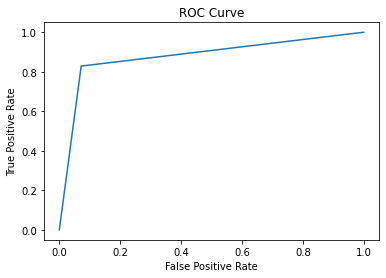

In [16]:
# Build a Artificial Neural Network model and compare the results

from pyspark.ml.classification import MultilayerPerceptronClassifier

# Split the data into train and test
train, test = X.randomSplit([0.7, 0.3], seed=42)

# Build a Artificial Neural Network model
layers = [57, 10, 5, 2]

# create the trainer and set its parameters
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
mlp_model = mlp.fit(train)

# Make predictions
predictions = mlp_model.transform(test)

# Evaluate the model by predicting the test data and giving the speed of the model, Error rate, ROC and AUC

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

accuracy = evaluator.evaluate(predictions)
print('Accuracy: ', accuracy)
output_cache["MLP"]["accuracy"] = accuracy

# Print the confusion matrix
predictions.groupBy('label', 'prediction').count().show()

# Print the ROC and AUC
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
auc = evaluator.evaluate(predictions)
print('AUC: ', auc)
output_cache["MLP"]["AUC"] = auc

# Compute ROC curve and ROC area for each class
preds = predictions.select('label', 'prediction').rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = CurveMetrics(preds)
points = metrics.get_curve('roc')

# Plot the ROC curve
plt.plot([p[0] for p in points], [p[1] for p in points])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Accuracy:  0.9306930693069307
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   62|
|    0|       0.0|  743|
|    1|       1.0|  479|
|    0|       1.0|   29|
+-----+----------+-----+

AUC:  0.923916322680126


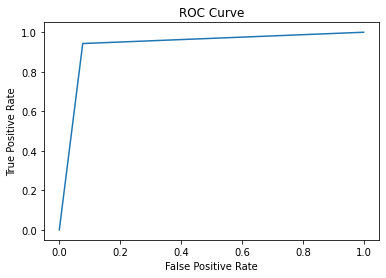

In [17]:
# Build AdaBoost model and compare the results
from pyspark.ml.classification import GBTClassifier

# Split the data into train and test
train, test = X.randomSplit([0.7, 0.3], seed=42)

# Build a AdaBoost model
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10)

# train the model
gbt_model = gbt.fit(train)

# Make predictions
predictions = gbt_model.transform(test)

# Evaluate the model by predicting the test data and giving the speed of the model, Error rate, ROC and AUC
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

accuracy = evaluator.evaluate(predictions)
print('Accuracy: ', accuracy)
output_cache["AdaBoost"]["accuracy"] = accuracy

# Print the confusion matrix
predictions.groupBy('label', 'prediction').count().show()

# Print the ROC and AUC
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
auc = evaluator.evaluate(predictions)
print('AUC: ', auc)
output_cache["AdaBoost"]["AUC"] = auc

# Compute ROC curve and ROC area for each class
preds = predictions.select('label', 'prediction').rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = CurveMetrics(preds)
points = metrics.get_curve('roc')

# Plot the ROC curve
plt.plot([p[0] for p in points], [p[1] for p in points])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

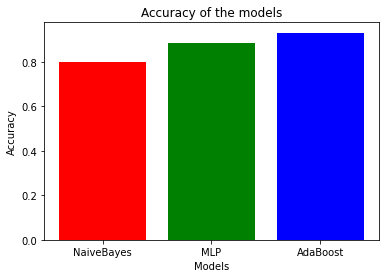

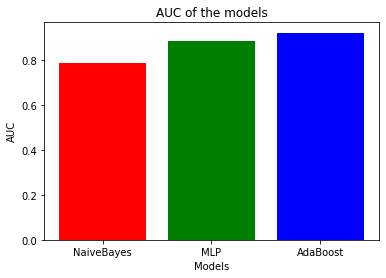

In [18]:
# plot the accuracies and AUCs of the models

# Plot the accuracies with bar chart and different colors
accuracies = [output_cache[model]["accuracy"] for model in output_cache]
plt.bar(range(len(accuracies)), accuracies, color=['red', 'green', 'blue'])
plt.xticks(range(len(accuracies)), list(output_cache.keys()))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of the models')
plt.show()


# Plot the AUCs with bar chart and different colors
aucs = [output_cache[model]["AUC"] for model in output_cache]
plt.bar(range(len(aucs)), aucs, color=['red', 'green', 'blue'])
plt.xticks(range(len(aucs)), list(output_cache.keys()))
plt.xlabel('Models')
plt.ylabel('AUC')
plt.title('AUC of the models')
plt.show()

In [19]:
# Run the models with different test sizes

test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
output_accuracies = {
    'Naive Bayes': [],
    'MLP': [],
    'AdaBoost': []
}

# Run the models with different test sizes
for test_size in test_sizes:
  model1 = NaiveBayes()
  model2 = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
  model3 = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10)
  models = [model1, model2, model3]
  model_names = ['Naive Bayes', 'MLP', 'AdaBoost']
  for model, model_name in zip(models, model_names):
    train, test = X.randomSplit([1-test_size, test_size], seed=42)
    model = model.fit(train)
    predictions = model.transform(test)
    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
    accuracy = evaluator.evaluate(predictions)
    print('Accuracy of {} with test size {}: {}'.format(model_name, test_size, accuracy))
    output_accuracies[model_name].append(accuracy)
  print('-'*50)

Accuracy of Naive Bayes with test size 0.1: 0.7852494577006508
Accuracy of MLP with test size 0.1: 0.8785249457700651
Accuracy of AdaBoost with test size 0.1: 0.9219088937093276
--------------------------------------------------
Accuracy of Naive Bayes with test size 0.2: 0.797945205479452
Accuracy of MLP with test size 0.2: 0.867579908675799
Accuracy of AdaBoost with test size 0.2: 0.9360730593607306
--------------------------------------------------
Accuracy of Naive Bayes with test size 0.3: 0.7974105102817974
Accuracy of MLP with test size 0.3: 0.8834729626808835
Accuracy of AdaBoost with test size 0.3: 0.9306930693069307
--------------------------------------------------
Accuracy of Naive Bayes with test size 0.4: 0.809255079006772
Accuracy of MLP with test size 0.4: 0.8775395033860045
Accuracy of AdaBoost with test size 0.4: 0.927765237020316
--------------------------------------------------
Accuracy of Naive Bayes with test size 0.5: 0.7982261640798226
Accuracy of MLP with test

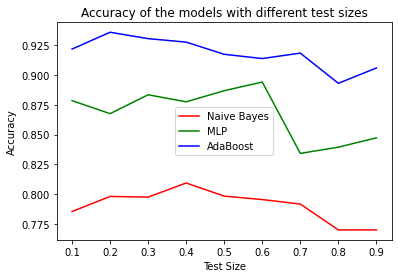

In [20]:
# plot the accuracies of the models with different test sizes

# Plot the accuracies with line chart and different colors
plt.plot(test_sizes, output_accuracies['Naive Bayes'], color='red', label='Naive Bayes')
plt.plot(test_sizes, output_accuracies['MLP'], color='green', label='MLP')
plt.plot(test_sizes, output_accuracies['AdaBoost'], color='blue', label='AdaBoost')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.title('Accuracy of the models with different test sizes')
plt.legend()
plt.show()
